# Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = xPlus.twiss_b2_from_b4(twiss['b4'])


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)






# Creating IP objects!

In [43]:
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.1e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

--- 

# Beam-beam separation

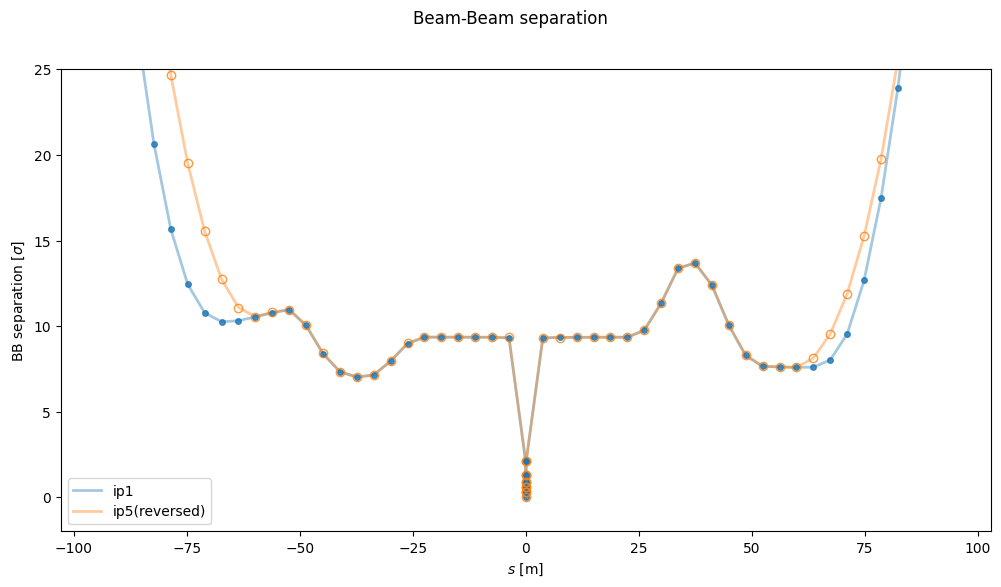

In [39]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_sig_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_sig_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_sig_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_sig_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_sig_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])

# Plotting full octupolar footprint

In [31]:
B1.emittx

3.449053778366961e-10

Execution time, HO: 0.157 s
Execution time, LR: 0.041 s
Execution time, HO: 0.155 s
Execution time, LR: 0.041 s


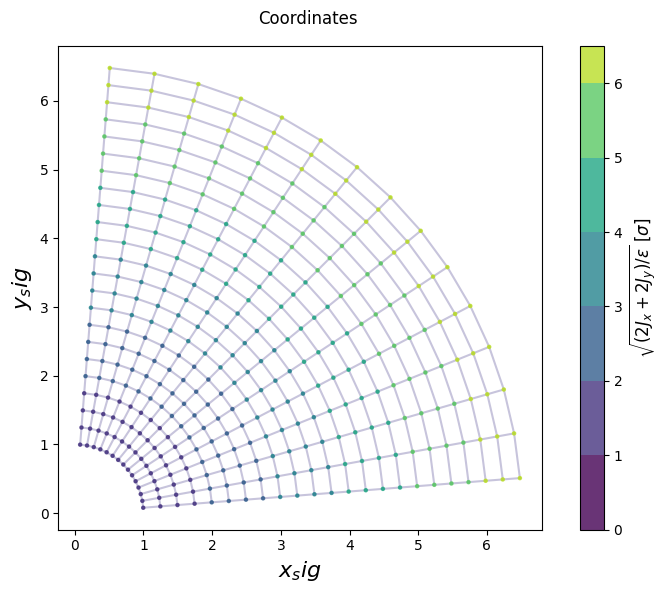

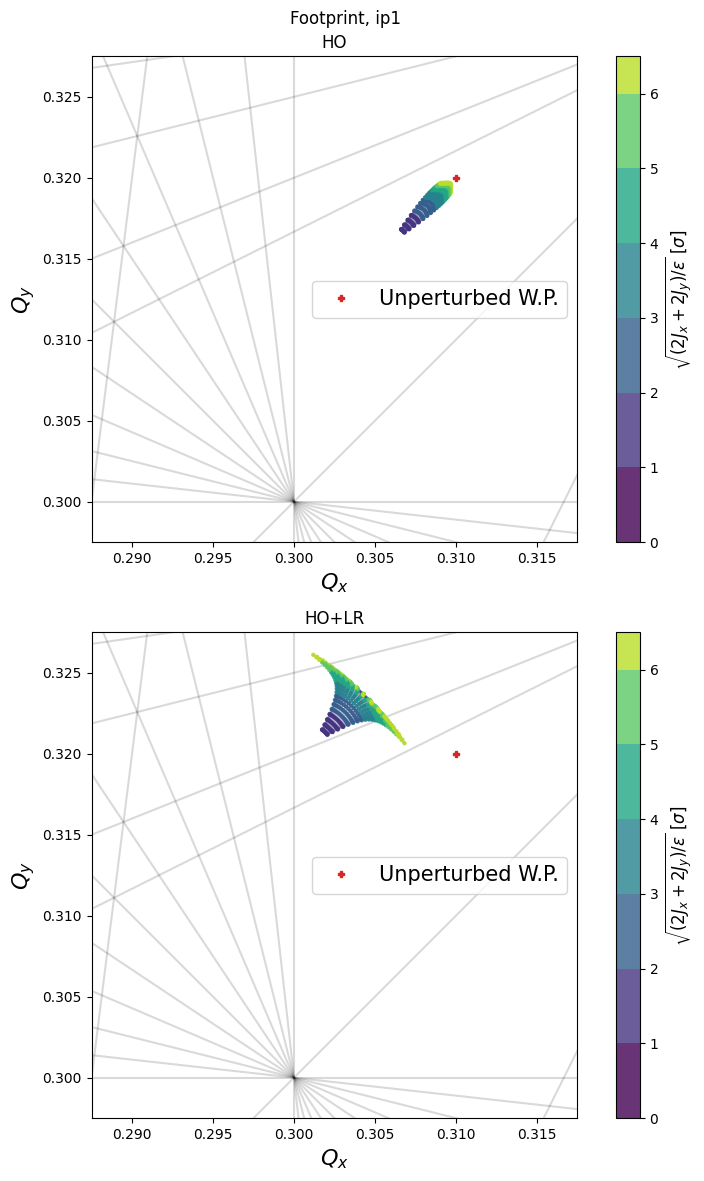

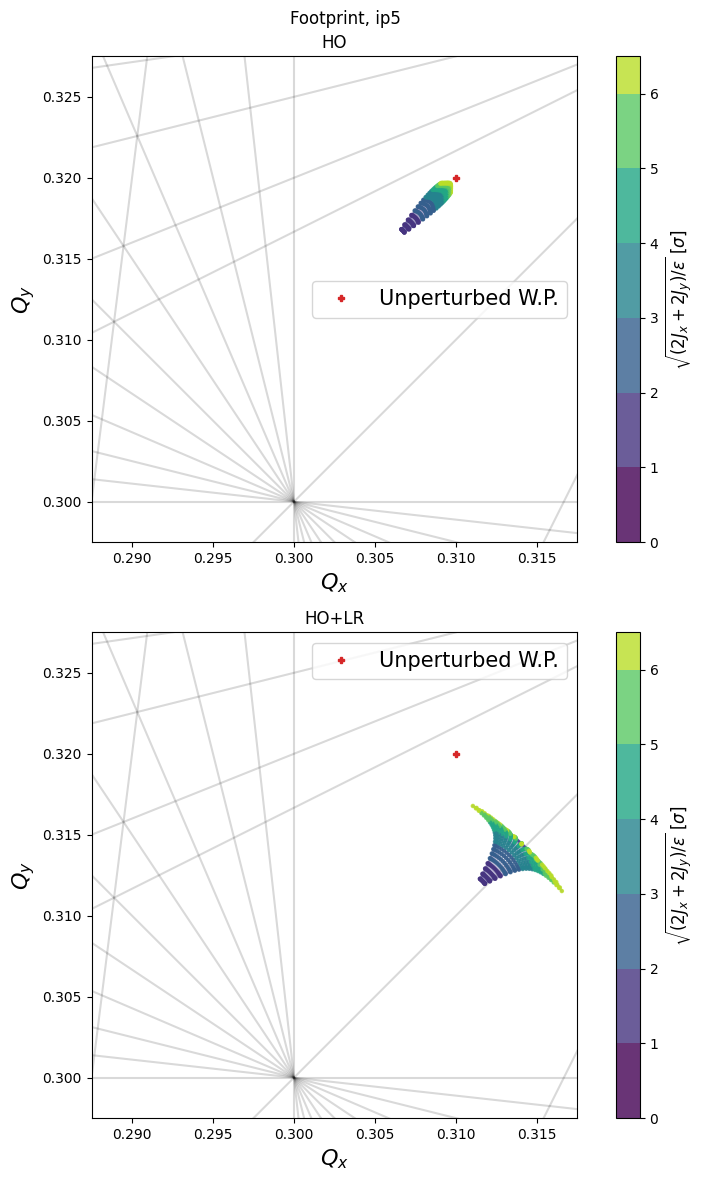

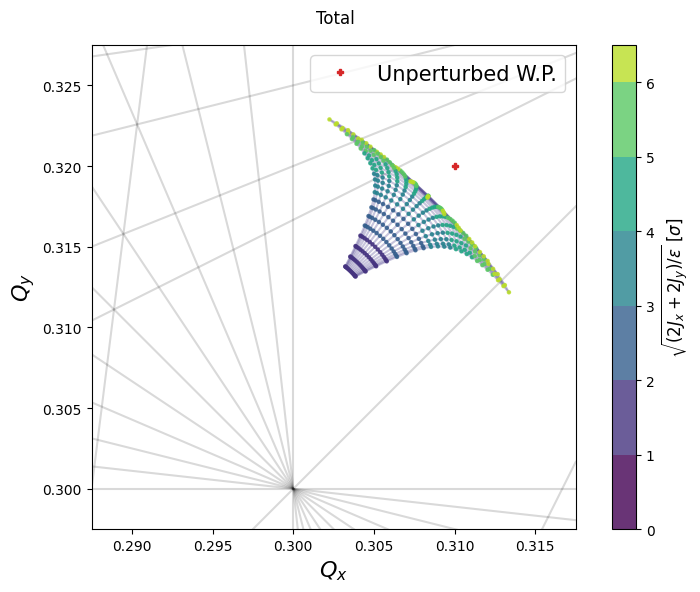

In [46]:
import time

# Generating Coord grid
#=========================================================
# coordinates = phys.polar_grid(  r_sig     = np.linspace(0,4,5),#np.logspace(np.log10(0.5),np.log10(7),10),
#                                 theta_sig = np.linspace(0.01*np.pi/2,0.99*np.pi/2,7),
#                                 emitt   = [B1.emittx,B1.emitty])

coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                emitt     = [B1.emittx,B1.emitty])
coordinates.insert(0,'delta',0)


# Plotting coordinates
#-----------------------
plt.figure(figsize=(8,6))
cmap = 'viridis'
cmax = int(np.max(coordinates['r_sig'])+1)
boundaries = np.linspace(0,cmax,cmax+1)

plt.suptitle('Coordinates')

bbplt.polarmesh(coordinates['x_sig'],coordinates['y_sig'],r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(coordinates['x_sig'],coordinates['y_sig'],c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')

plt.xlabel(r'$x_sig$',fontsize=16);
plt.ylabel(r'$y_sig$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.tight_layout()
#=========================================================


window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

DQx_total,DQy_total = np.zeros(len(coordinates)),np.zeros(len(coordinates))
for IP in [IP1,IP5]:
    DQx_IP,DQy_IP = np.zeros(len(coordinates)),np.zeros(len(coordinates))
    
    # Generic HO
    _bb = IP.ho.loc[IP.ho.index[len(IP.ho)//2]]

    s_time = time.time()
    _DQx,_DQy = dtune.HeadOn_round( ax    = coordinates['x_sig'],
                                    ay    = coordinates['y_sig'],
                                    r     = _bb['r'],
                                    emitt = IP.b2.emittx,
                                    xi    = IP.b2.xi/np.sqrt(2))

    DQx_total += _DQx
    DQy_total += _DQy
    DQx_IP    += _DQx
    DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, HO: {(e_time-s_time):.3f} s')

    
    fig,axes = plt.subplots(2,1,figsize=(8,12))
    fig.suptitle(f'Footprint, {IP.name}')

    # Plotting HO only
    #-----------------------
    plt.sca(axes[0])
    plt.gca().set_title('HO')

    def plot_IP_tune():
        bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=10,color='k',alpha=0.15)
        bbplt.polarmesh(Qx_0 + DQx_IP,Qy_0 + DQy_IP,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
        bbplt.boundedScatter(Qx_0 + DQx_IP,Qy_0 + DQy_IP,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
        plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

        plt.legend(fontsize=15)
        plt.xlabel(r'$Q_x$',fontsize=16);
        plt.ylabel(r'$Q_y$',fontsize=16);
        plt.axis('square');
        cbar = plt.colorbar()
        plt.set_cmap(cmap)
        cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
        cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
        plt.xlim(Qx_lim)
        plt.ylim(Qy_lim)
    plot_IP_tune()


    # Generic LR
    s_time = time.time()
    for index, _bb in IP.lr.iterrows():

        lr_num = int(_bb.name.split('b1_')[1])
        # if 12 < lr_num < 16:
        #     pass
        # else:
        #     continue  

        _DQx,_DQy = dtune.BBLR_octupole(    coordinates['J_x'],
                                            coordinates['J_y'],
                                            betx = _bb['betx'],
                                            bety = _bb['bety'],
                                            k1   = _bb['k1'],
                                            k3   = _bb['k3'])
        DQx_total += _DQx
        DQy_total += _DQy
        DQx_IP    += _DQx
        DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, LR: {(e_time-s_time):.3f} s')

    plt.sca(axes[1])
    plt.gca().set_title('HO+LR')
    plot_IP_tune()

    plt.tight_layout()



plt.figure(figsize=(8,6))
plt.suptitle(f'Total')

bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=10,color='k',alpha=0.15)
bbplt.polarmesh(Qx_0 + DQx_total,Qy_0 + DQy_total,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(Qx_0 + DQx_total,Qy_0 + DQy_total,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15)
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()





In [48]:
coordinates

,delta,r_sig,theta_sig,x_sig,y_sig,x_n,y_n,J_x,J_y
0,0,1.00,0.078540,0.996917,0.078459,0.000019,0.000001,1.713911e-10,1.061589e-12
1,0,1.25,0.078540,1.246147,0.098074,0.000023,0.000002,2.677986e-10,1.658733e-12
2,0,1.50,0.078540,1.495376,0.117689,0.000028,0.000002,3.856300e-10,2.388576e-12
3,0,1.75,0.078540,1.744605,0.137303,0.000032,0.000003,5.248852e-10,3.251117e-12
4,0,2.00,0.078540,1.993835,0.156918,0.000037,0.000003,6.855644e-10,4.246358e-12
...,...,...,...,...,...,...,...,...,...
340,0,5.50,1.492257,0.431525,5.483045,0.000008,0.000102,3.211308e-11,5.184581e-09
341,0,5.75,1.492257,0.451140,5.732275,0.000008,0.000106,3.509880e-11,5.666618e-09
342,0,6.00,1.492257,0.470755,5.981504,0.000009,0.000111,3.821722e-11,6.170080e-09
343,0,6.25,1.492257,0.490369,6.230733,0.000009,0.000116,4.146834e-11,6.694965e-09


Execution time, HO: 16.202 s
LR:  25
Execution time, LR: 179.126 s
----------------------------------------
LR:  24
Execution time, LR: 161.066 s
----------------------------------------
LR:  23
Execution time, LR: 147.521 s
----------------------------------------
LR:  22
Execution time, LR: 122.306 s
----------------------------------------
LR:  21
Execution time, LR: 97.926 s
----------------------------------------
LR:  20
Execution time, LR: 83.001 s
----------------------------------------
LR:  19
Execution time, LR: 68.897 s
----------------------------------------
LR:  18
Execution time, LR: 62.357 s
----------------------------------------
LR:  17
Execution time, LR: 58.752 s
----------------------------------------
LR:  16
Execution time, LR: 58.176 s
----------------------------------------
LR:  15
Execution time, LR: 57.775 s
----------------------------------------
LR:  14
Execution time, LR: 57.898 s
----------------------------------------
LR:  13
Execution time, LR: 67.

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:60: RuntimeWarning: overflow encountered in double_scalars
  return sign*np.exp(-X-2*Y)/2/np.pi * integratedFactor
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:85: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-t/2*(azbar-dzbar)**2)*Bess2D(X,Y,0)
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:140: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda t: dC00dy_generating(t,ax,ay,r,dx_n,dy_n,method), 0, 1)[0]


Execution time, LR: 194.251 s
----------------------------------------
Execution time, LR: 4815.339 s
Execution time, HO: 16.906 s
LR:  25
Execution time, LR: 188.272 s
----------------------------------------
LR:  24
Execution time, LR: 178.291 s
----------------------------------------
LR:  23
Execution time, LR: 158.937 s
----------------------------------------
LR:  22
Execution time, LR: 142.281 s
----------------------------------------
LR:  21
Execution time, LR: 126.031 s
----------------------------------------
LR:  20
Execution time, LR: 104.502 s
----------------------------------------
LR:  19
Execution time, LR: 91.197 s
----------------------------------------
LR:  18
Execution time, LR: 76.709 s
----------------------------------------
LR:  17
Execution time, LR: 66.901 s
----------------------------------------
LR:  16
Execution time, LR: 61.991 s
----------------------------------------
LR:  15
Execution time, LR: 61.953 s
----------------------------------------
LR:  

/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:60: RuntimeWarning: overflow encountered in double_scalars
  return sign*np.exp(-X-2*Y)/2/np.pi * integratedFactor
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:85: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-t/2*(azbar-dzbar)**2)*Bess2D(X,Y,0)
/home/phbelang/abp/BBStudies/Tests/../BBStudies/Physics/Detuning.py:140: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda t: dC00dy_generating(t,ax,ay,r,dx_n,dy_n,method), 0, 1)[0]


Execution time, LR: 231.757 s
----------------------------------------
Execution time, LR: 4935.042 s


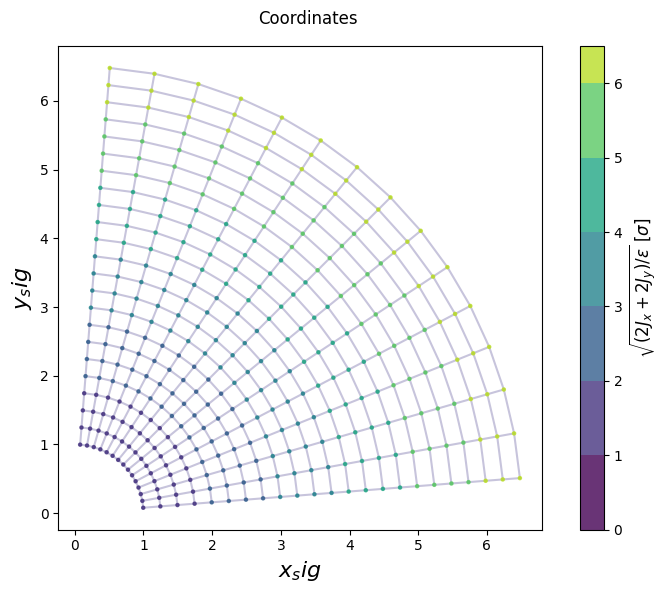

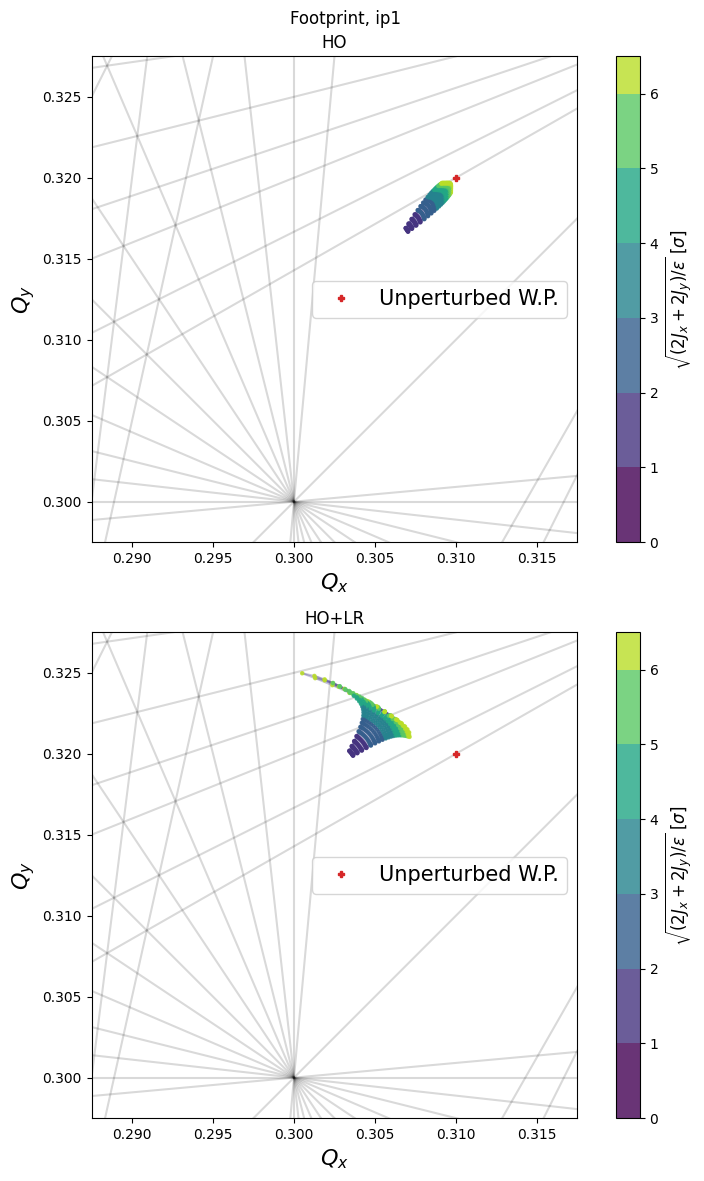

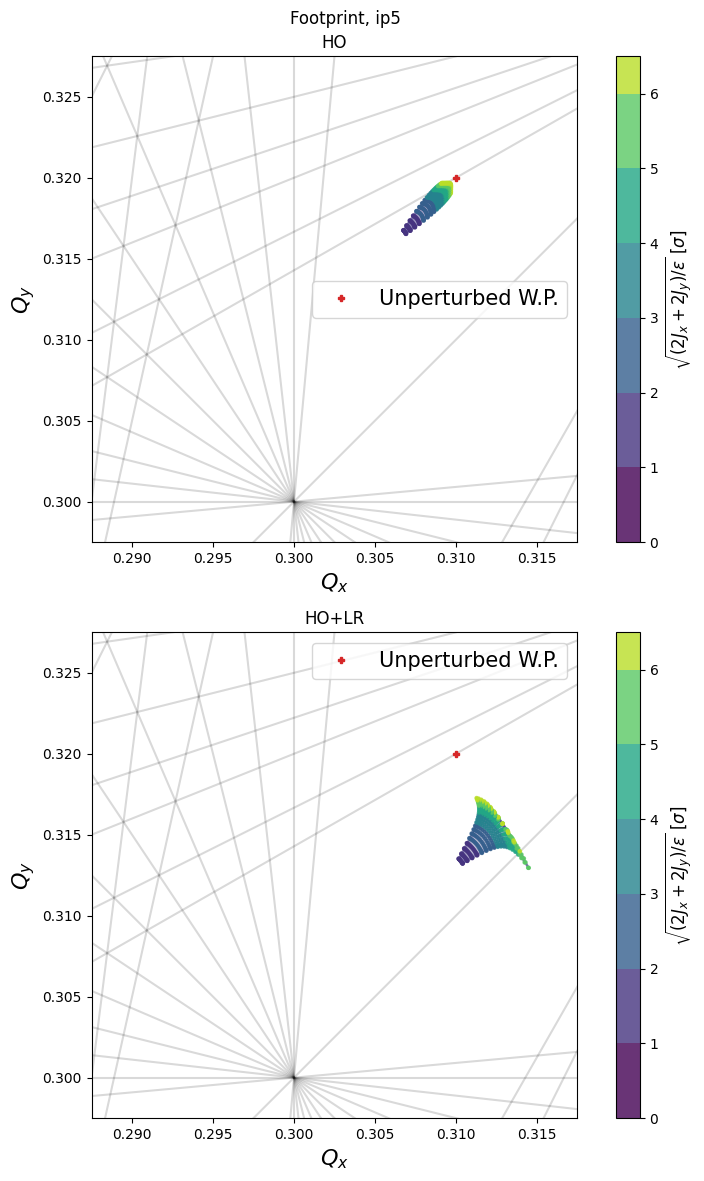

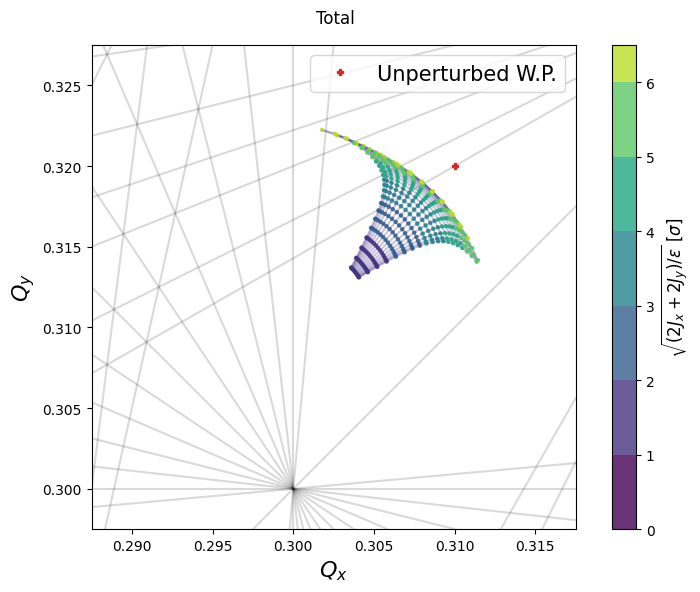

In [47]:
import time

# Generating Coord grid
#=========================================================
# coordinates = phys.polar_grid(  r_sig     = np.linspace(0,4,5),#np.logspace(np.log10(0.5),np.log10(7),10),
#                                 theta_sig = np.linspace(0.01*np.pi/2,0.99*np.pi/2,7),
#                                 emitt   = [B1.emittx,B1.emitty])

coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                emitt     = [B1.emittx,B1.emitty])
coordinates.insert(0,'delta',0)


# Plotting coordinates
#-----------------------
plt.figure(figsize=(8,6))
cmap = 'viridis'
cmax = int(np.max(coordinates['r_sig'])+1)
boundaries = np.linspace(0,cmax,cmax+1)

plt.suptitle('Coordinates')

bbplt.polarmesh(coordinates['x_sig'],coordinates['y_sig'],r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(coordinates['x_sig'],coordinates['y_sig'],c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')

plt.xlabel(r'$x_sig$',fontsize=16);
plt.ylabel(r'$y_sig$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.tight_layout()
#=========================================================


window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

DQx_total,DQy_total = np.zeros(len(coordinates)),np.zeros(len(coordinates))
for IP in [IP1,IP5]:
    DQx_IP,DQy_IP = np.zeros(len(coordinates)),np.zeros(len(coordinates))
    
    # Generic HO
    _bb = IP.ho.loc[IP.ho.index[len(IP.ho)//2]]

    s_time = time.time()
    _DQx,_DQy = dtune.DQx_DQy( ax  = coordinates['x_sig'],
                            ay   = coordinates['y_sig'],
                            r    = _bb['r'],
                            dx_n = _bb['dx_n'],
                            dy_n = _bb['dy_n'],
                            A_w_s= _bb['A_w_s'],
                            B_w_s= _bb['B_w_s'],
                            xi   = IP5.b2.xi/np.sqrt(2))

    

    DQx_total += _DQx
    DQy_total += _DQy
    DQx_IP    += _DQx
    DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, HO: {(e_time-s_time):.3f} s')

    
    fig,axes = plt.subplots(2,1,figsize=(8,12))
    fig.suptitle(f'Footprint, {IP.name}')

    # Plotting HO only
    #-----------------------
    plt.sca(axes[0])
    plt.gca().set_title('HO')

    def plot_IP_tune():
        bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=12,color='k',alpha=0.15)
        bbplt.polarmesh(Qx_0 + DQx_IP,Qy_0 + DQy_IP,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
        bbplt.boundedScatter(Qx_0 + DQx_IP,Qy_0 + DQy_IP,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
        plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

        plt.legend(fontsize=15)
        plt.xlabel(r'$Q_x$',fontsize=16);
        plt.ylabel(r'$Q_y$',fontsize=16);
        plt.axis('square');
        cbar = plt.colorbar()
        plt.set_cmap(cmap)
        cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
        cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
        plt.xlim(Qx_lim)
        plt.ylim(Qy_lim)
    plot_IP_tune()


    # Generic LR
    s_time = time.time()
    for index, _bb in IP.lr.iterrows():

        lr_num = int(_bb.name.split('b1_')[1])
        # if 12 < lr_num < 16:
        #     pass
        # else:
        #     continue 
        # 
        print('LR: ',lr_num)
        s_sub_time = time.time()
        _DQx,_DQy = dtune.DQx_DQy(  ax   = coordinates['x_sig'],
                                    ay   = coordinates['y_sig'],
                                    r    = _bb['r'],
                                    dx_n = _bb['dx_n'],
                                    dy_n = _bb['dy_n'],
                                    A_w_s= _bb['A_w_s'],
                                    B_w_s= _bb['B_w_s'],
                                    xi   = IP.b2.xi/np.sqrt(2)) 
        e_sub_time = time.time()
        print(f'Execution time, LR: {(e_sub_time-s_sub_time):.3f} s')
        print(40*'-')
        # _DQx,_DQy = dtune.BBLR_octupole(    coordinates['J_x'],
        #                                     coordinates['J_y'],
        #                                     betx = _bb['betx'],
        #                                     bety = _bb['bety'],
        #                                     k1   = _bb['k1'],
        #                                     k3   = _bb['k3'])
        DQx_total += _DQx
        DQy_total += _DQy
        DQx_IP    += _DQx
        DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, LR: {(e_time-s_time):.3f} s')

    plt.sca(axes[1])
    plt.gca().set_title('HO+LR')
    plot_IP_tune()

    plt.tight_layout()



plt.figure(figsize=(8,6))
plt.suptitle(f'Total')

bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=12,color='k',alpha=0.15)
bbplt.polarmesh(Qx_0 + DQx_total,Qy_0 + DQy_total,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(Qx_0 + DQx_total,Qy_0 + DQy_total,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15)
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()

plt.savefig('Analytic_footprint.png',format='png',dpi=300)



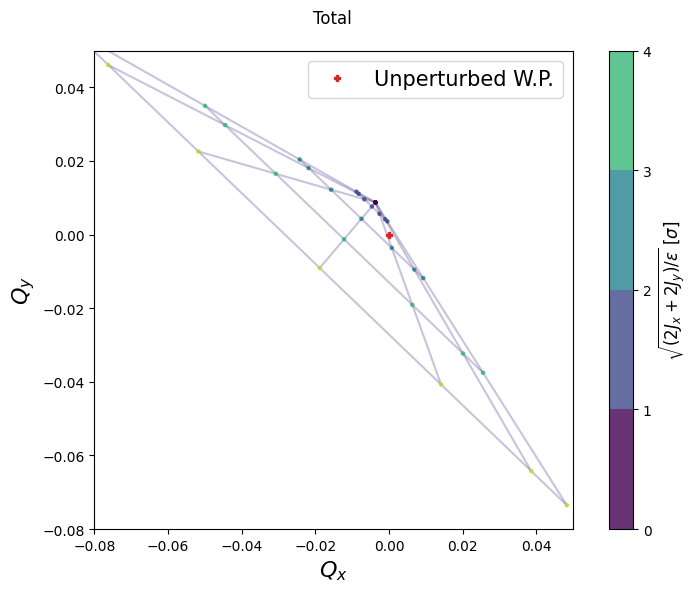

In [25]:
plt.figure(figsize=(8,6))
plt.suptitle(f'Total')

#bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=10,color='k',alpha=0.15)
bbplt.polarmesh(DQx_total/B1.xi,DQy_total/B1.xi,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(DQx_total/B1.xi,DQy_total/B1.xi,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
plt.plot([0],[0],'P',markersize=5,color='C3',label='Unperturbed W.P.')


plt.legend(fontsize=15)
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.xlim([-0.08,0.05])
plt.ylim([-0.08,0.05])
plt.tight_layout()


# More on the working diagram

In [28]:
B1.xi

0.005617860836878258

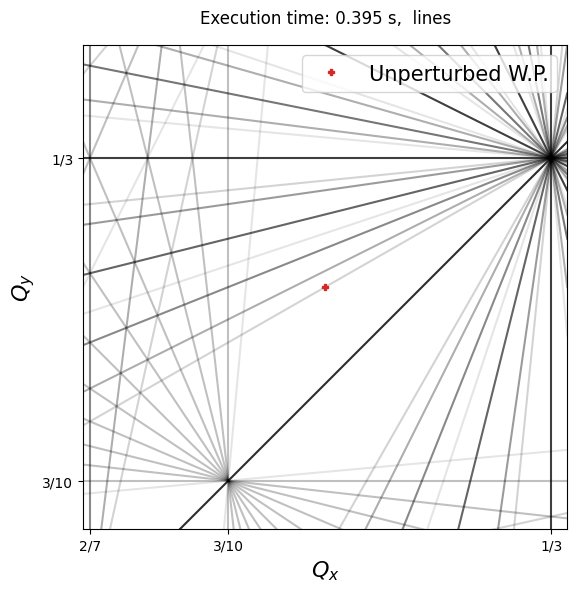

In [6]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)
alphas = np.linspace(0.1,0.9,len(orders))[::-1]

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,alpha in zip(orders,alphas):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',alpha=alpha)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()


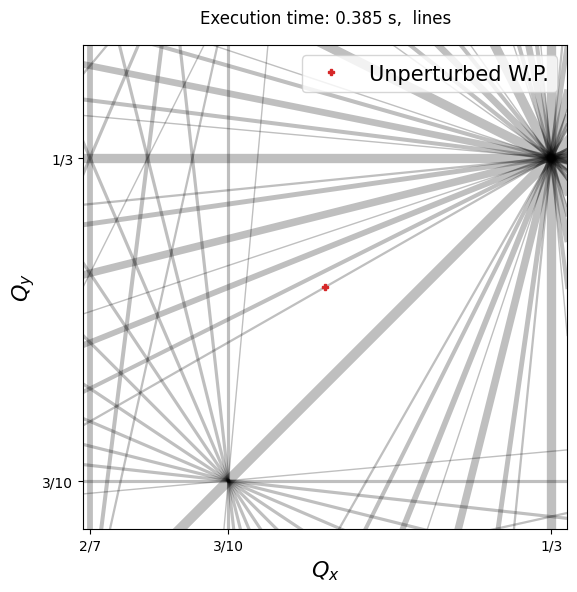

In [8]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)[::-1]
lws    = np.linspace(1,8,len(orders))

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,lw in zip(orders,lws):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=0.25)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()


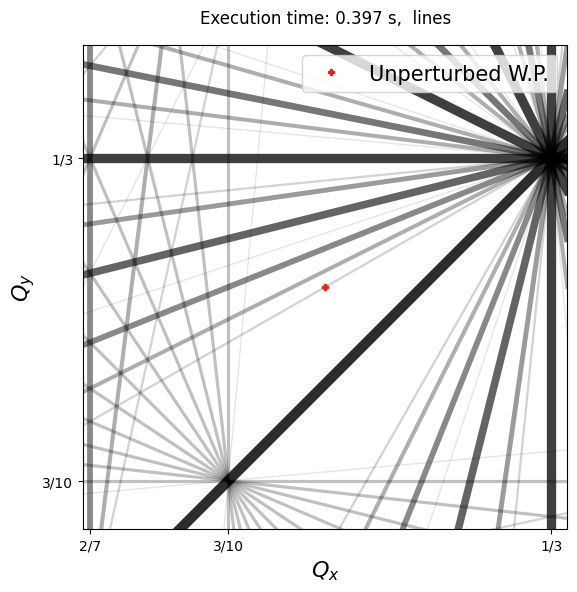

In [9]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)[::-1]
lws    = np.linspace(1,8,len(orders))
alphas = np.linspace(0.1,0.9,len(orders))

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,lw,alpha in zip(orders,lws,alphas):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=alpha)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()


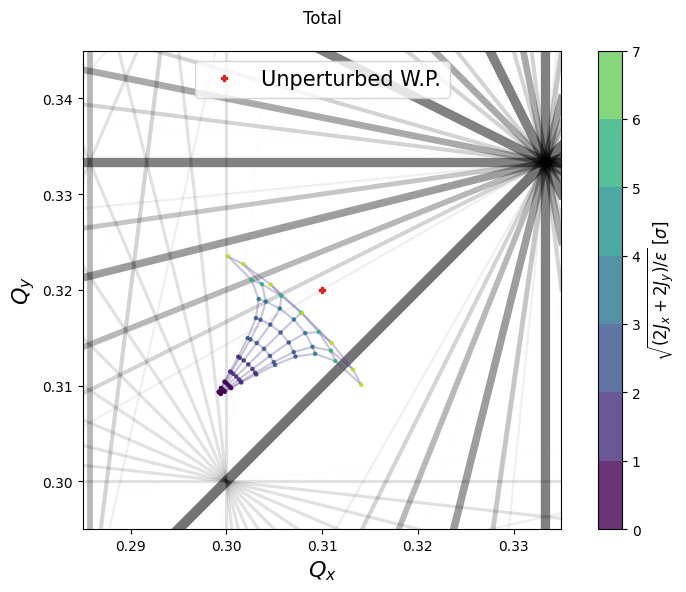

In [10]:
ORDER = 12
orders = list(np.arange(ORDER)+1)[::-1]
lws    = np.linspace(1,8,len(orders))
alphas = np.linspace(0.01,0.6,len(orders))


plt.figure(figsize=(8,6))
plt.suptitle(f'Total')

for order,lw,alpha in zip(orders,lws,alphas):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=alpha)
bbplt.polarmesh(Qx_0 + DQx_total,Qy_0 + DQy_total,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
bbplt.boundedScatter(Qx_0 + DQx_total,Qy_0 + DQy_total,c=coordinates['r_sig'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15)
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_sig'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()

